In [262]:
import pickle
import numpy as np
from random import shuffle
import agent_code.my_agent.algorithms as alg
from settings import s
import time
import matplotlib.pyplot as plt


In [282]:
file = open('C:/Users/Lily/Documents/UNI/FML/project/local_branch/data-collection/75-crate-no-opponents.pickle', 'rb')
data = pickle.load(file)
data = sorted(data, key=lambda k: k['state']['step'])

In [283]:
# to easily change to different game states
i = 35

#extract information from game_state
game_state = data[i]['state']

agent = game_state['self']
actions = s.actions

arena = game_state['arena']
explosions = game_state['explosions']
bombs = game_state['bombs']
game_state.keys()

dict_keys(['step', 'arena', 'self', 'others', 'bombs', 'coins', 'explosions', 'user_input', 'exit'])

In [284]:
'''
for each action, we calculate the agent location after taking said action.
We call this action coordinate
'''
action_coord = np.array([[agent[0], agent[1]-1],
                        [agent[0], agent[1]+1],
                        [agent[0]-1, agent[1]],
                        [agent[0]+1, agent[1]],
                        [agent[0], agent[1]],
                        [agent[0], agent[1]]])
#accessing action coordinates on the arena
arena[action_coord[:, 0], action_coord[:,1]]


array([0, 0, 1, 0, 0, 0])

In [285]:
def bomb_range(bomb, arena): 
    #see the sides of a bomb
    bomb_sides = np.array([[bomb[0], bomb[1]-1], #up
                           [bomb[0], bomb[1]+1], #down
                           [bomb[0]-1, bomb[1]], #left
                           [bomb[0]+1, bomb[1]]]) #right
    #check_walls check if there's any walls next to a bomb
    check_walls = arena[bomb_sides[:, 0], bomb_sides[:,1]]
    #theoretical range of bomb without walls             
    explosion = np.array([bomb[1]-s.bomb_power, #up
                          bomb[1]+s.bomb_power, #down
                          bomb[0]-s.bomb_power, #left
                          bomb[0]+s.bomb_power]) #right
    
    explosion[np.where(check_walls == -1)] = 0
    
    return explosion

In [286]:
def bomb_map(arena, bombs): 
    bomb_map = np.ones(arena.shape) * 5
    for xb,yb,t in bombs:
        for (i,j) in [(xb+h, yb) for h in range(-3,4)] + [(xb, yb+h) for h in range(-3,4)]:
            if (0 < i < bomb_map.shape[0]) and (0 < j < bomb_map.shape[1]):
                bomb_map[i,j] = min(bomb_map[i,j], t)
                    
    return bomb_map

In [287]:
abs(agent_loc[0]- explosions[:,0]) + abs(agent_loc[1] - explosions[:,1])

array([14., 14., 14., 14., 14., 14., 14., 14., 14., 14., 14., 14., 14.,
       14., 14., 14., 14.])

In [288]:
start = time.time()
bomb_map(arena, bombs)
end = time.time()
print(end-start)


start = time.time()
bomb_range(bomb, arena)
end = time.time()
print(end-start)

0.0
0.0


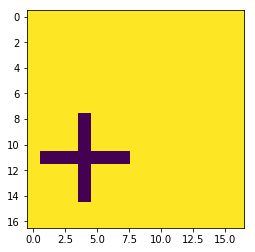

In [289]:
plt.imshow(bomb_map(arena, bombs))
#print(bomb_map(arena, bombs))

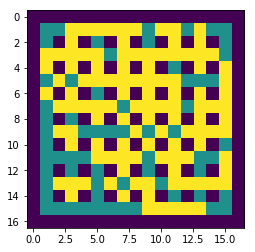

In [290]:
plt.imshow(arena)

In [335]:
def feat_dist_to_safe(game_state):
    '''
    We begin by extracting all relevant information 
    '''
    res = np.zeros(6, dtype=np.int8)
    if len(bombs) != 0:
        '''
        create map of explosion, similar to simple_agent
        from this map, we extract the locations of possible
        explosions (the x and y values) and save them in 
        the matrix explosions
        '''
        explosions = bomb_map(arena, bombs)
        explosions = np.argwhere(explosions < 5)
        
        '''
        we then mark these explosions on our map. here we deep-copy
        the arena, so that in the case that the arena is needed for
        other features, it remains unchanged
        '''
        map = copy.deepcopy(arena)
        map[explosions[:,0], explosions[:,1]] = 2
        
        '''
        to take consideration of only the necessary area and not the whole map,
        we create a patch of the map surrounding where the explosions will be.
        To do this, we calculate the min_x, min_y, max_x, and max_y of the explosion
        locations and create a box surrounding all the explosions using these points
        '''
        min_x = np.amin(explosions[:,0])-1%17
        min_y = np.amin(explosions[:,1])-1%17
        max_x = np.amax(explosions[:,0])+2%17
        max_y = np.amax(explosions[:,1])+2%17
        
        patch = map[ min_x:max_x, min_y:max_y ]
        #print(patch)

        '''
        now that we have the patch with all the explosions marked, we can find the 
        safe locations on the map. These would be the tiles marked as 0 
        '''
        safe_loc = np.argwhere(patch==0)
        #print(safe_loc)
        
        '''
        we then calculate the minimum distance of our agent to any of these safe locations.
        For simplicity, only Manhattan distance is used to calculate distance in this
        feature extraction. However, this doesn't always represent the true distance in the 
        game because of the walls.(Possible point of improvement?)
        '''
        agent_loc = np.array([agent[0], agent[1]])
        dist_to_safe = np.min(abs(agent_loc[0]- safe_loc[:,0]) + abs(agent_loc[1] - safe_loc[:,1]))
        print(dist_to_safe)
        
        '''
        Then, we calculate the positions of our agent after taking all possible actions.
        '''
        actions_loc = np.array([[agent[0], agent[1]-1],
                                [agent[0], agent[1]+1],
                                [agent[0]-1, agent[1]],
                                [agent[0]+1, agent[1]],
                                [agent[0], agent[1]],
                                [agent[0], agent[1]]])
        '''
        For each of these new positions, we then calculate the minimum distance from the new 
        position to the safe locations.
        '''
        new_dist_to_safe = [np.min(abs(action[0]- safe_loc[:,0]) + 
                                  abs(action[1] - safe_loc[:,1])) for action in actions_loc]
        
        '''
        
        '''
        temp = dist_to_safe - new_dist_to_safe 
        res[np.where(t<0)] = 1

    print(res)
    

3
[0 0 0 1 0 0]
